In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, util
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

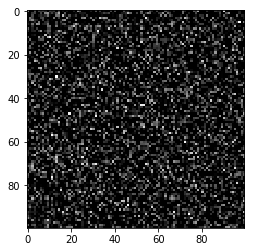

In [3]:
fig, ax = plt.subplots()
image = np.zeros((100,100), np.float32)
image = util.random_noise(image, var=.1)
im = ax.imshow(image, cmap='gray', animated=True)

def init():
    return (im,)

def animate(i):
    image = np.zeros((100,100), np.float32)
    noise = util.random_noise(image, var=.1)
    im.set_data(noise)
    return (im,)

In [4]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
#rc('animation', html='html5')
anim
HTML(anim.to_html5_video())